In [39]:
import pandas as pd

In [40]:
from sklearn.model_selection import train_test_split

/tmp/ipykernel_1026/2062325061.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),
/home/wealthiercorps/miniconda3/envs/gpu-wsl/lib/python3.12/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


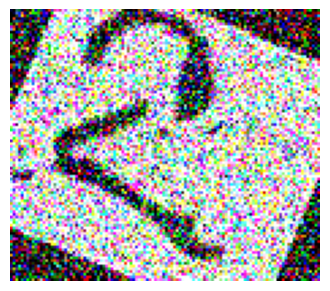

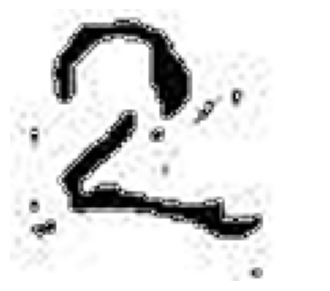

Augmentation complete. Saved up to 1000 images in ./dataset/newDataset/24/


In [2]:
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch
import matplotlib.pyplot as plt

# Maximum total output images
MAX_TOTAL_IMAGES = 1000

def augment_image(image):
    transform = A.Compose([
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=10, p=0.3),
        A.GaussianBlur(blur_limit=(1, 3), p=0.2),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])
    return transform(image=image)['image']

def invert_colors(image):
    if np.mean(image) < 127:  # Ensure black text, white background
        image = 255 - image
    return image

def augment_and_save(input_dir, output_dir, upscale_factor=2, max_aug_per_image=500):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    img_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    total_images = len(img_files)

    if total_images == 0:
        print("No valid images found in input directory.")
        return

    # Determine augmentations per image to not exceed MAX_TOTAL_IMAGES
    remaining_slots = MAX_TOTAL_IMAGES
    remaining_images = total_images

    for img_name in img_files:
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Skipping {img_name}: Not a valid image.")
            continue

        image = invert_colors(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Increase resolution using cubic interpolation
        height, width = image.shape[:2]
        upscale_size = (width * upscale_factor, height * upscale_factor)
        image = cv2.resize(image, upscale_size, interpolation=cv2.INTER_CUBIC)

        # Calculate allowed augmentations for this image
        num_augmentations = min(max_aug_per_image, remaining_slots // remaining_images)

        for i in range(num_augmentations):
            augmented_image = augment_image(image)
            save_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug{i}.png")
            augmented_image = (augmented_image.mul(255).byte().cpu().numpy()).transpose(1, 2, 0)  # Convert to NumPy RGB
            cv2.imwrite(save_path, augmented_image)

            # Show sample images (optional)
            if i < 2:  # Display only 2 samples per input
                plt.figure(figsize=(4, 4))
                plt.imshow(augmented_image)
                plt.axis("off")
                plt.show()

        # Update remaining slots
        remaining_slots -= num_augmentations
        remaining_images -= 1

        if remaining_slots <= 0:
            break  # Stop when we reach the 1000 image limit

    print(f"Augmentation complete. Saved up to {MAX_TOTAL_IMAGES} images in {output_dir}")

if __name__ == "__main__":
    input_directory = "./dataset/OneDrive_2025-03-20/New characters/24/"
    output_directory = "./dataset/newDataset/24/"
    augment_and_save(input_directory, output_directory)


In [42]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("iris.csv")  # Change file path if needed

# Encode categorical target variable
df["species"] = LabelEncoder().fit_transform(df["species"])

# Define features and target
X, y = df.drop(columns=["species"]), df["species"]

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(knn, X, y, cv=cv)

# Compute evaluation metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'iris.csv'

In [13]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

def split_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    for dir_path in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        train_files, test_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        val_files, test_files = train_test_split(test_files, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

        for dataset_type, dataset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            class_output_path = os.path.join(output_dir, dataset_type, class_name)
            if not os.path.exists(class_output_path):
                os.makedirs(class_output_path)

            for file in dataset_files:
                src_path = os.path.join(class_path, file)
                dst_path = os.path.join(class_output_path, file)
                shutil.copy2(src_path, dst_path)

    print(f"Dataset split into train:{train_ratio*100}%, val:{val_ratio*100}%, test:{test_ratio*100}%")

if __name__ == "__main__":
    input_directory = "./dataset/newDataset/"  # Path to the original dataset
    output_directory = "./dataset/newDatasetSplit/"    # Path where the split dataset will be stored
    split_dataset(input_directory, output_directory)


Dataset split into train:70.0%, val:15.0%, test:15.0%


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU 0

import tensorflow as tf
print("Using GPU:", tf.config.experimental.list_physical_devices('GPU'))

2025-03-26 18:25:50.247585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743013550.256299    1960 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743013550.258765    1960 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743013550.267932    1960 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743013550.267955    1960 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743013550.267957    1960 computation_placer.cc:177] computation placer alr

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [ ]:
import tensorflow as tf
cuda_version = tf.sysconfig.get_build_info().get("cuda_version", "CUDA version not available")
print(cuda_version)

12.5.1


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import os

def rename_files_in_folder(folder_path, prefix="file_", start_index=1):
    """
    Renames all files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the files.
        prefix (str): Prefix to add to the new filenames. Default is "file_".
        start_index (int): Starting number for the new filenames. Default is 1.
    """
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return

    # Get a list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Rename each file
    for index, filename in enumerate(files, start=start_index):
        # Get the file extension
        file_extension = os.path.splitext(filename)[1]

        # Create the new filename
        new_filename = f"{prefix}{index}{file_extension}"

        # Get the full paths for the old and new filenames
        old_file_path = os.path.join(folder_path, filename)
        new_file_path = os.path.join(folder_path, new_filename)

        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f"Renamed: {filename} -> {new_filename}")

    print("All files have been renamed.")

# Example usage
folder_path = "./dataset/OneDrive_2025-03-20/New characters/24/" # Replace with the path to your folder
rename_files_in_folder(folder_path, prefix="image_", start_index=1)

Renamed: 130.JPG -> image_1.JPG
All files have been renamed.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0
